activate conda environment anopheles.yml

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import sys

import os, io, random
import string

In [2]:
#import test files
name='Burkina-Faso'
manifestname = 'Burkina-Faso-meta.tsv'
haplotypes = pd.read_csv("haplotypes-vignette-Burkina-Faso.tsv", sep='\t')
meta = pd.read_csv(manifestname, sep='\t')

In [3]:
#Import reference files
refbase = pd.read_csv("../../data/haplotypes/haplotypes-NNv1.csv")
td = pd.read_csv("../../analysis/1_species-groups-thresholds/sample_info.csv", index_col=0)

### Clean up metadata and restrict to mosquitoes

In [4]:
#Compare numbers
print("metadata table has ", meta["SUPPLIER SAMPLE NAME"].nunique(), " unique IDs, haplotypes has ", haplotypes.s_Sample.nunique(), ' unique IDs ')

metadata table has  960  unique IDs, haplotypes has  937  unique IDs 


Check that haplotype IDs are contained and check which are the ones that fail.

In [5]:
np.isin(haplotypes.s_Sample.unique(), meta["SUPPLIER SAMPLE NAME"].unique()).all()

True

In [6]:
meta.loc[~np.isin(meta["SUPPLIER SAMPLE NAME"], haplotypes.s_Sample.unique())]

,SUPPLIER SAMPLE NAME,SERIES,ASP-PROJ CODE-COUNTRY CODE-MMYY-PLATENO,RACK_OR_PLATE_ID,TUBE_OR_WELL_ID,ORGANISM_PART,CATCH_ID,ORDER_OR_GROUP,FAMILY,GENUS,...,res_coarse,res_int,res_fine,n_mosquito_targets,mosquito_reads,mean_mosquito_haps,n_multiallelic,VAE_species,species_call,call_method
95,DN806231V_H12,96.0,ASP-BUMI-BF-2103-01,PLATE1,H12,BLANK_SAMPLE,NOT_APPLICABLE,NOT_APPLICABLE,NOT_APPLICABLE,NOT_APPLICABLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOO_FEW_TARGETS,TOO_FEW_TARGETS
146,DN806232W_C7,147.0,ASP-BUMI-BF-2103-02,PLATE2,C7,WHOLE_ORGANISM,Tube20,Diptera,Culicidae,Anopheles,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOO_FEW_TARGETS,TOO_FEW_TARGETS
185,DN806232W_B12,186.0,ASP-BUMI-BF-2103-02,PLATE2,B12,WHOLE_ORGANISM,Tube24,Diptera,Culicidae,Anopheles,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOO_FEW_TARGETS,TOO_FEW_TARGETS
191,DN806232W_H12,192.0,ASP-BUMI-BF-2103-02,PLATE2,H12,BLANK_SAMPLE,NOT_APPLICABLE,NOT_APPLICABLE,NOT_APPLICABLE,NOT_APPLICABLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOO_FEW_TARGETS,TOO_FEW_TARGETS
287,DN806233A_H12,288.0,ASP-BUMI-BF-2103-03,PLATE3,H12,BLANK_SAMPLE,NOT_APPLICABLE,NOT_APPLICABLE,NOT_APPLICABLE,NOT_APPLICABLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOO_FEW_TARGETS,TOO_FEW_TARGETS
383,DN806234B_H12,384.0,ASP-BUMI-BF-2103-04,PLATE4,H12,BLANK_SAMPLE,NOT_APPLICABLE,NOT_APPLICABLE,NOT_APPLICABLE,NOT_APPLICABLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOO_FEW_TARGETS,TOO_FEW_TARGETS
479,DN806235C_H12,480.0,ASP-BUMI-BF-2103-05,PLATE5,H12,BLANK_SAMPLE,NOT_APPLICABLE,NOT_APPLICABLE,NOT_APPLICABLE,NOT_APPLICABLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOO_FEW_TARGETS,TOO_FEW_TARGETS
530,DN806236D_C7,531.0,ASP-BUMI-BF-2103-06,PLATE6,C7,WHOLE_ORGANISM,Tube83,Diptera,Culicidae,Anopheles,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOO_FEW_TARGETS,TOO_FEW_TARGETS
575,DN806236D_H12,576.0,ASP-BUMI-BF-2103-06,PLATE6,H12,BLANK_SAMPLE,NOT_APPLICABLE,NOT_APPLICABLE,NOT_APPLICABLE,NOT_APPLICABLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOO_FEW_TARGETS,TOO_FEW_TARGETS
671,DN806237E_H12,672.0,ASP-BUMI-BF-2103-07,PLATE7,H12,BLANK_SAMPLE,NOT_APPLICABLE,NOT_APPLICABLE,NOT_APPLICABLE,NOT_APPLICABLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOO_FEW_TARGETS,TOO_FEW_TARGETS


Ten fails are blank samples (one per plate)
And another 13 mosquitoes failed.

In [7]:
#Remove plasmodium targets (should already be removed for the vignettes)
haplotypes = haplotypes.loc[~haplotypes.target.isin(['P1', 'P2'])]
haplotypes.target = haplotypes.target.astype('int')
print(haplotypes.shape, haplotypes.s_Sample.nunique())

(71646, 6) 937


In [8]:
#All uppercase
print(haplotypes.shape)
haplotypes['consensus'] = haplotypes['consensus'].str.upper()
haplotypes = haplotypes.drop_duplicates()
haplotypes.shape

(71646, 6)


(71646, 6)

### Functions

In [9]:
def construct_kmer_dict(k):
    labels = []
    for i in itertools.product('ACGT', repeat=k):
        labels.append(''.join(i))
    kmerdict = dict(zip(labels, np.arange(4**k)))
    return(kmerdict)

In [10]:
def assign_combUID(haplotypes): 
    # assign IDs to unique sequences
    combuids = dict()
    for tgt, group in haplotypes.groupby(['target']):
        for (i, cons) in enumerate(group['consensus'].unique()):
            combuids[str(tgt)+cons] = '{}-{}'.format(tgt, i)
    haplotypes['combUID'] = (haplotypes.target.astype('str') + haplotypes.consensus).replace(combuids)
    return(haplotypes)

In [11]:
def sample_kmer_table(k, seq, no_amp, x):
    kmerdict = construct_kmer_dict(k)
    table = np.zeros((no_amp, x, 4**k), dtype='int')
    for r in seq.index:
        combid = str.split(seq.loc[r,'combUID'], '-')
        t, u = int(combid[0]), int(combid[1])
        sq = seq.loc[r,'consensus']
        for i in np.arange(len(sq)-(k-1)):
            table[t,u,kmerdict[sq[i:i+k]]] += 1
    return(table)

In [12]:
def construct_unique_kmer_array(k, hap, no_amp):
    # assign IDs to unique sequences if column combUID does not exist
    if not 'combUID' in hap.columns:
        hap = assign_combUID(hap)
    
    maxallele = hap.groupby('target')['combUID'].nunique().max()
    
    combUIDunique = hap[['combUID', 'consensus']].drop_duplicates()
    
    kmercombUID = sample_kmer_table(k, combUIDunique, no_amp, maxallele)
    
    return(kmercombUID, hap)

In [13]:
#Main function
#Currently very slow, look into how to speed up

def clade_assignment(testseq, testkmers, refseq, refkmers, maxima, n_targets):
    gps_coarse = refbase.coarse_sgp.cat.categories
    gps_int = refbase.intermediate_sgp.cat.categories
    gps_fine  = refbase.fine_sgp.cat.categories
    
    targets_per_sample = testseq.groupby('s_Sample')['target'].nunique()
    testsamples = targets_per_sample[targets_per_sample>9].index
    
    #set up data-output (will be made into dataframes later)
    res_coarse = np.zeros((n_targets, len(testsamples), len(gps_coarse)))
    res_int = np.zeros((n_targets, len(testsamples), len(gps_int)))
    res_fine = np.zeros((n_targets, len(testsamples), len(gps_fine)))
    
    #Split refseq into a dataframe per target
    refseq_per_target = refseq.groupby('target')
    
    #Go through the test samples one by one
    print("assign {} samples".format(len(testsamples)))
    for nsmp, smp in enumerate(testsamples):
        #Restrict to amplified targets
        targets = testseq.loc[testseq.s_Sample == smp, 'target'].unique()
        
        #Per amplified target
        for t in targets:
            #Per allele
            alleles = testseq.loc[(testseq.s_Sample == smp) & (testseq.target == t), 'combUID']
            for allele in alleles:
                UID = int(allele.split('-')[1])
                #Compute difference between target and references, with length correction
                a = np.sum(np.abs(refkmers[t,:int(maxima[t]),:] - testkmers[t,UID,:]), axis=1)/ np.sum((refkmers[t,:int(maxima[t]),:] + testkmers[t,UID,:]), axis=1)
                #Find minimal neighbours
                cbn = np.arange(int(maxima[t]))[a==a.min()]
                nncombuid = ['{}-{}'.format(t,x) for x in cbn]
                #include neighbour column weighed by zygosity
                refseq_t = refseq_per_target.get_group(t).copy()
                nndict = dict(refseq_t['combUID'].isin(nncombuid)*refseq_t['zygosity'])
                refseq_t['neighbours'] = refseq_t.index.map(nndict)
                
                #Now store assignment scores proportional to allele frequency
                for level, table in zip(['fine_sgp', 'intermediate_sgp', 'coarse_sgp'], [res_fine, res_int, res_coarse]):
                    #per level, compute the neighbour allele frequency
                    #because refseq is categorical, it should record all levels in the same order
                    nsum = refseq_t.groupby(level)['neighbours'].sum()
                    zsum = refseq_t.groupby(level)['zygosity'].sum()
                    nb = nsum/zsum
                    #normalise such that per sample neighbour frequency is 2 (diploid)
                    table[t,nsmp,:] += (2/len(alleles))*nb/np.sum(nb)
        if nsmp % 20 == 0:
            print("sample {} done".format(nsmp))
  
    #Save per target assigments for future reference
    np.save("assignment_fine_per_target.npy", res_fine)
    np.save("assignment_intermediate_per_target.npy", res_int)
    np.save("assignment_coarse_per_target.npy", res_coarse)
    
    #Make result tables into dataframes
    rc = np.nansum(res_coarse, axis=0)/np.sum(np.nansum(res_coarse, axis=0), axis=1)[:,None]
    result_coarse = pd.DataFrame(rc, index=testsamples, columns=refbase.coarse_sgp.cat.categories)
    result_coarse.to_csv("assignment_coarse.csv")
    ri = np.nansum(res_int, axis=0)/np.sum(np.nansum(res_int, axis=0), axis=1)[:,None]
    result_intermediate = pd.DataFrame(ri, index=testsamples, columns=refbase.intermediate_sgp.cat.categories)
    result_intermediate.to_csv("assignment_intermediate.csv")
    rf = np.nansum(res_fine, axis=0)/np.sum(np.nansum(res_fine, axis=0), axis=1)[:,None]
    result_fine = pd.DataFrame(rf, index=testsamples, columns=refbase.fine_sgp.cat.categories)
    result_fine.to_csv("assignment_fine.csv")
        
    return(result_coarse, result_intermediate, result_fine)

### Dataprep refset

In [14]:
#Assign combUIDs to refdatabase
refbase = assign_combUID(refbase)
#Add column with zygosity information
#Add allelic zygosity
zygosity = 2/refbase.groupby(['s_Sample', 'target'])['combUID'].nunique()
zygosity = pd.DataFrame(zygosity).reset_index()
zygosity_dict = dict(zip(zygosity.s_Sample + zygosity.target.astype('str'), zygosity.combUID))
refbase['zygosity'] = (refbase.s_Sample + refbase.target.astype('str')).replace(zygosity_dict)
#Check that all samples sum to 2
(refbase.groupby(['s_Sample', 'target'])['zygosity'].sum()==2).all()

True

In [15]:
#Include group information in refbase dataframe
tdfdict = dict(zip(td.index, td.fine_sgp))
tdidict = dict(zip(td.index, td.intermediate_sgp))
tdcdict = dict(zip(td.index, td.coarse_sgp))
refbase['fine_sgp'] = refbase.s_Sample.map(tdfdict)
refbase['intermediate_sgp'] = refbase.s_Sample.map(tdidict)
refbase['coarse_sgp'] = refbase.s_Sample.map(tdcdict)

In [16]:
#make refbase entries categorical
refbase['fine_sgp'] = pd.Categorical(refbase['fine_sgp'], ['Anopheles_marshallii_complex', 'Anopheles_marshallii_cp_sp1',
       'Anopheles_theileri', 'Anopheles_moucheti', 'Anopheles_jebudensis',
       'Myzomyia_sp1', 'Anopheles_gabonensis', 'Anopheles_funestus',
       'Anopheles_rhodesiensis', 'Anopheles_minimus_A',
       'Anopheles_culicifacies', 'Anopheles_aconitus', 'Anopheles_rampae',
       'Anopheles_maculatus_A', 'Anopheles_maculatus_B',
       'Anopheles_maculipalpis', 'Anopheles_annularis',
       'Anopheles_jamesii', 'Anopheles_stephensi',
       'Anopheles_gambiae_coluzzii', 'Anopheles_arabiensis',
       'Anopheles_gambiae_cp_sp1', 'Anopheles_quadriannulatus',
       'Anopheles_melas', 'Anopheles_merus', 'Anopheles_christyi',
       'Anopheles_sundaicus_complex', 'Anopheles_vagus',
       'Anopheles_dirus_A', 'Anopheles_balabacensis', 'Anopheles_cracens',
       'Anopheles_koliensis', 'Anopheles_farauti',
       'Anopheles_punctulatus', 'Anopheles_tessellatus',
       'Anopheles_coustani_cp_cl3', 'Anopheles_coustani_cp_cl2', 
       'Anopheles_coustani_cp_cl1', 'Anopheles_hyrcanus_gp_sp1', 
       'Anopheles_hyrcanus_gp_sp2', 'Anopheles_sinensis',
       'Anopheles_barbirostris', 'Anopheles_atroparvus',
       'Anopheles_implexus', 'Anopheles_nili_gp_sp3',
       'Anopheles_nili_gp_sp2', 'Anopheles_nili_gp_sp1',
       'Anopheles_carnevalei', 'Anopheles_vinckei', 'Anopheles_dureni',
       'Anopheles_aquasalis', 'Anopheles_oryzalimnetes',
       'Anopheles_darlingi', 'Anopheles_albimanus', 'Anopheles_cruzii',
       'Anopheles_bellator'], ordered=True)
refbase['intermediate_sgp'] = pd.Categorical(refbase['intermediate_sgp'],['Anopheles_marshallii_group', 'Anopheles_moucheti_group',
       'Myzomyia_sp1', 'Anopheles_gabonensis', 'Anopheles_funestus',
       'Anopheles_rhodesiensis', 'Anopheles_minimus_A',
       'Anopheles_culicifacies', 'Anopheles_aconitus',
       'Anopheles_maculatus_group', 'Anopheles_maculipalpis',
       'Anopheles_annularis', 'Anopheles_jamesii', 'Anopheles_stephensi',
       'Anopheles_gambiae_complex', 'Anopheles_christyi',
       'Anopheles_sundaicus_complex', 'Anopheles_vagus',
       'Anopheles_dirus_complex', 'Anopheles_punctulatus_group',
       'Anopheles_tessellatus', 'Anopheles_coustani_complex',
       'Anopheles_hyrcanus_gp_sp1', 'Anopheles_sinensis_group',
       'Anopheles_barbirostris', 'Anopheles_atroparvus',
       'Anopheles_implexus', 'Anopheles_nili_group', 'Anopheles_vinckei',
       'Anopheles_dureni', 'Anopheles_aquasalis',
       'Anopheles_oryzalimnetes', 'Anopheles_darlingi',
       'Anopheles_albimanus', 'Kerteszia_subgenus'], ordered=True)
refbase['coarse_sgp'] = pd.Categorical(refbase['coarse_sgp'], ['Myzomyia_Neocellia_series', 'Pyretophorus_series',
       'Neomyzomyia_series_I', 'Myzorhynchus_series', 'Christya_series',
       'Neomyzomyia_series_II', 'Neomyzomyia_series_III',
       'Nyssorhynchus_subgenus', 'Kerteszia_subgenus'], ordered=True)

In [17]:
#Show refbase
refbase.head()

,s_Sample,target,consensus,combUID,zygosity,fine_sgp,intermediate_sgp,coarse_sgp
0,Abro-21,13,CATTTCTATCTGATGAAACTTGTGCCCGTGGTTTAATTAATGCGTA...,13-0,2.0,Anopheles_marshallii_complex,Anopheles_marshallii_group,Myzomyia_Neocellia_series
1,Abro-21,17,GGTCTAGACCCGGAAGCCCTCACCGGCAAATACCCGGTAAGTGTTT...,17-0,2.0,Anopheles_marshallii_complex,Anopheles_marshallii_group,Myzomyia_Neocellia_series
2,Abro-21,18,AAAAAGGATGAGGTGAGTACCAGACTCCTCCCAGAATGATTATAAT...,18-0,2.0,Anopheles_marshallii_complex,Anopheles_marshallii_group,Myzomyia_Neocellia_series
3,Abro-21,19,TATTTGTCCACCTTTTGCCGACCGAGTTTTCTTGCCCGAGACGCGT...,19-0,2.0,Anopheles_marshallii_complex,Anopheles_marshallii_group,Myzomyia_Neocellia_series
4,Abro-21,24,AATGTAGCCCCGAGCGCGAAGCCGTGAAGCTTCTGCGCGCCACCTC...,24-0,2.0,Anopheles_marshallii_complex,Anopheles_marshallii_group,Myzomyia_Neocellia_series


In [18]:
#Make unique k-mer table for the reference base
ref8mers, refbase = construct_unique_kmer_array(k=8, hap=refbase, no_amp=62)

In [19]:
#Record number of unique k-mers per target for refset
maxima = refbase.groupby('target')['combUID'].nunique()

### Dataprep testset

In [20]:
test8mers, haplotypes = construct_unique_kmer_array(k=8, hap=haplotypes, no_amp=62)

In [22]:
result_coarse, result_intermediate, result_fine = clade_assignment(testseq=haplotypes, testkmers=test8mers, refseq=refbase, 
                                                                   refkmers=ref8mers, maxima=maxima, n_targets=62)

In [38]:
#Produce hard calls
meta.loc[meta.s_Sample.isin(result_coarse.index), 'assigned'] = True
for result, rescol in zip([result_coarse, result_intermediate, result_fine], ['res_coarse', 'res_int', 'res_fine']):
    adict = dict(result.loc[(result>=.8).any(axis=1)].apply(lambda row: result.columns[row>=0.8][0], axis=1))
    meta[rescol] = meta.s_Sample.map(adict)
meta.head()

,SERIES,ASP-PROJ CODE-COUNTRY CODE-MMYY-PLATENO,RACK_OR_PLATE_ID,TUBE_OR_WELL_ID,ORGANISM_PART,CATCH_ID,ORDER_OR_GROUP,FAMILY,GENUS,SCIENTIFIC_NAME,...,PARENT_RT_TICKET_NUMBER,CHILD_RT_TICKET_NUMBER,SCIOPS_MANIFEST_NUMBER,MANIFEST_SENT_TO_SCIOPS,SAMPLES_SUBMITTED_TO_SCIOPS,s_Sample,assigned,res_coarse,res_int,res_fine
0,1,ASP-BUMI-BF-2103-01,PLATE1,A1,WHOLE_ORGANISM,Tube1,Diptera,Culicidae,Anopheles,Anopheles gambiae group_guess,...,719287,719431,17065,2021-06-25,2021-06-25,DN806231V_A1,True,Pyretophorus_series,Anopheles_gambiae_complex,NaN
1,2,ASP-BUMI-BF-2103-01,PLATE1,B1,WHOLE_ORGANISM,Tube1,Diptera,Culicidae,Anopheles,Anopheles gambiae group_guess,...,719287,719431,17065,2021-06-25,2021-06-25,DN806231V_B1,True,Pyretophorus_series,Anopheles_gambiae_complex,NaN
2,3,ASP-BUMI-BF-2103-01,PLATE1,C1,WHOLE_ORGANISM,Tube1,Diptera,Culicidae,Anopheles,Anopheles gambiae group_guess,...,719287,719431,17065,2021-06-25,2021-06-25,DN806231V_C1,True,Pyretophorus_series,Anopheles_gambiae_complex,NaN
3,4,ASP-BUMI-BF-2103-01,PLATE1,D1,WHOLE_ORGANISM,Tube1,Diptera,Culicidae,Anopheles,Anopheles gambiae group_guess,...,719287,719431,17065,2021-06-25,2021-06-25,DN806231V_D1,True,Pyretophorus_series,Anopheles_gambiae_complex,NaN
4,5,ASP-BUMI-BF-2103-01,PLATE1,E1,WHOLE_ORGANISM,Tube1,Diptera,Culicidae,Anopheles,Anopheles gambiae group_guess,...,719287,719431,17065,2021-06-25,2021-06-25,DN806231V_E1,True,Pyretophorus_series,Anopheles_gambiae_complex,NaN


### Collect other statistics

In [ ]:
targetdict = dict(haplotypes.groupby(['s_Sample'])['target'].nunique())
readdict = dict(haplotypes.groupby(['s_Sample'])['reads'].sum())
alleledict = dict(pd.DataFrame(haplotypes.groupby(['s_Sample', 'target'])['consensus'].nunique()).reset_index().groupby(['s_Sample'])['consensus'].mean())
multidict = dict(pd.DataFrame(haplotypes.groupby(['s_Sample', 'target'])['consensus'].nunique()>2).reset_index().groupby(['s_Sample'])['consensus'].sum())

meta['n_mosquito_targets'] = meta['SUPPLIER SAMPLE NAME'].map(targetdict)
meta['mosquito_reads'] = meta['SUPPLIER SAMPLE NAME'].map(readdict)
meta['mean_mosquito_haps'] = meta['SUPPLIER SAMPLE NAME'].map(alleledict)
meta['n_multiallelic'] = meta['SUPPLIER SAMPLE NAME'].map(multidict)

In [ ]:
meta.to_csv('{}_results.tsv'.format(name), sep='\t')

### Collect gambiae complex samples

In [ ]:
#Restrict to gambiae complex
metagam = meta.loc[meta.res_int=='Anopheles_gambiae_complex']
gamsamples = metagam['SUPPLIER SAMPLE NAME']
hapgam = haplotypes.loc[haplotypes.s_Sample.isin(gamsamples)]
print(metagam.shape, hapgam.shape)

In [ ]:
#Construct per sample kmer table
#This includes samples with between 10 and 50 targets
#We project those onto latent space, but currently we don't assign them with the Convex Hulls
#Because the assignment is too affected by the lower coverage
k=8
no_amp=62

table = np.zeros((len(gamsamples), 4**k), dtype='int')

for e, smp in enumerate(gamsamples):
    smptable = np.zeros((no_amp, 4**k))
    smpseq = seq.loc[seq.s_Sample == smp]
    hapcopies = np.zeros(a)
    for r in smpseq.index:
        combUID = smpseq.loc[r, 'combUID']
        t, u = int(str.split(combUID, '-')[0]), int(str.split(combUID, '-')[1])
        if hapcopies[t] < 2:
            smptable[t,:] += kmer8[t, u, :]
            hapcopies[t] += 1
    for t in np.arange(a):
        #double homozygotes
        if hapcopies[t] == 1:
            smptable[t,:] *= 2
    table[e,:] = np.sum(smptable, axis=0)

In [ ]:
table.shape

In [ ]:
metagam[['SUPPLIER SAMPLE NAME', 'n_mosquito_targets']].to_csv("gambiae_complex/samples.csv", index=False)

In [ ]:
np.save("gambiae_complex/kmers.npy", table)

### VAE assignments

Next, run project the gambiae samples onto latent space using the notebook analysis/3_gambiae-complex-VAE/2_project_to_LS.ipynb, putting '../../tracking/Burkina-Faso/' as out. This will create a file gambiae_complex/latent_coords.csv containing the sample coordinates in VAE space. WARNING: this file also contains lower coverage samples (10 to 49 targets). For classification with Convex Hulls (next step) and plotting, you probably want to restrict to samples with at least 50 targets.

Then, classify species using the notebook analysis/4_Convex-Hull-assignments/1_assign_species.ipynb, setting '../../tracking/Burkina-Faso' as tracking_dir. This notebook subsets to high coverage samples (at least 50 targets) by default. This will create a file gambiae_complex/GC_assignments.tsv containing the assigned species label for the gambiae complex.

### Combined species calls

In [ ]:
gamcalls = pd.read_csv("gambiae_complex/GC_assignments.tsv", sep='\t')
gamcalls.head()

In [ ]:
gamspdict = dict(zip(gamcalls.sample_id, gamcalls.assigned_species))
meta['VAE_species'] = meta['SUPPLIER SAMPLE NAME'].map(gamspdict)
meta.head()

In [ ]:
#copy vae species
meta['species_call'] = meta['SUPPLIER SAMPLE NAME'].map(gamspdict)
meta.loc[~meta.species_call.isnull(), 'call_method'] = 'VAE'

#copy res_fine
finedict = dict(zip(meta['SUPPLIER SAMPLE NAME'], meta['res_fine']))
meta.loc[(meta.species_call.isnull()) & ~(meta.res_fine.isnull()), 'call_method'] = 'NN_FINE'
meta.loc[(meta.species_call.isnull()) & ~(meta.res_fine.isnull()), 'species_call'] = meta.loc[(meta.species_call.isnull()) 
                                                        & ~(meta.res_fine.isnull()), 'SUPPLIER SAMPLE NAME'].map(finedict)
#copy res_int
intdict = dict(zip(meta['SUPPLIER SAMPLE NAME'], meta['res_int']))
meta.loc[(meta.species_call.isnull()) & ~(meta.res_int.isnull()), 'call_method'] = 'NN_INTERMEDIATE'
meta.loc[(meta.species_call.isnull()) & ~(meta.res_int.isnull()), 'species_call'] = meta.loc[(meta.species_call.isnull()) 
                                                            & ~(meta.res_int.isnull()), 'SUPPLIER SAMPLE NAME'].map(intdict)
#copy res_coarse
coarsedict = dict(zip(meta['SUPPLIER SAMPLE NAME'], meta['res_coarse']))
meta.loc[(meta.species_call.isnull()) & ~(meta.res_coarse.isnull()), 'call_method'] = 'NN_COARSE'
meta.loc[(meta.species_call.isnull()) & ~(meta.res_coarse.isnull()), 'species_call'] = meta.loc[(meta.species_call.isnull()) 
                                                        & ~(meta.res_coarse.isnull()), 'SUPPLIER SAMPLE NAME'].map(coarsedict)
#rainbow samples
meta.loc[(meta.species_call.isnull()) & (meta.assigned==True), 'call_method'] == 'NN'
meta.loc[(meta.species_call.isnull()) & (meta.assigned==True), 'species_call'] = 'RAINBOW_SAMPLE'
#too few targets
meta.loc[(meta.assigned.isnull()), 'species_call'] = 'TOO_FEW_TARGETS'
meta.loc[(meta.assigned.isnull()), 'call_method'] = 'TOO_FEW_TARGETS'

In [ ]:
meta.groupby(['SCIENTIFIC_NAME', 'assigned', 
                  'species_call', 'call_method'], dropna=False)['SUPPLIER SAMPLE NAME'].count()

In [ ]:
meta= meta.set_index('SUPPLIER SAMPLE NAME')
meta.to_csv("{}_results.tsv".format(name), sep='\t')

### Plot NN assignment results

In [40]:
#Pick unique colors for each of the fine assignment categories
turquoise = np.concatenate([plt.cm.Dark2(np.arange(8))[:1], plt.cm.Set2(np.arange(8))[:1], plt.cm.Set3(np.arange(12))[:1], plt.cm.Pastel2(np.arange(8))[:1]])
yellows = np.concatenate([plt.cm.Set2(np.arange(8))[5:6], plt.cm.Set3(np.arange(12))[11:], plt.cm.Set1(np.arange(9))[5:6], plt.cm.Set3(np.arange(12))[1:2]])
blues = np.array([[5,8,84,200], [12,16,148,200], [0,8,255,200], [52,82,235,200]])/256
browns =  np.array([[56,22,6,200], [125,45,5,200], [148,67,27,200], [194, 72, 12, 200]])/256 
colorsb = plt.cm.tab20b(np.arange(20))
colorsc = plt.cm.tab20c(np.arange(20))
colors = np.concatenate([colorsb, colorsc, turquoise, yellows, blues, browns])
colors30 = np.delete(colors, [1,2,4,13,14,19,21,22,23,24,29,30,31,33,35,38,39,45,46,47,54], axis=0)
colors51 = colors[[17, 20, 28, 36, 43, 44, 48, 51, 55 ],:]

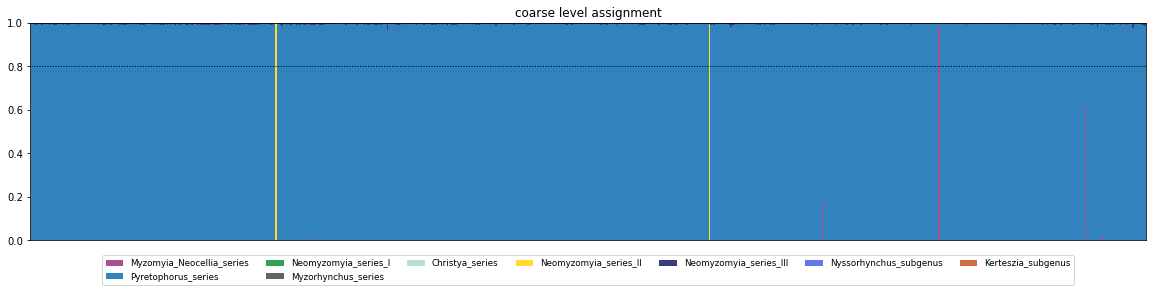

In [41]:
level='coarse'
assignment = result_coarse
levelcolor=colors51
fig, ax = plt.subplots(figsize=(20,7))
assignment.plot(kind='bar', stacked=True, width=1, ax=ax, color=levelcolor)
ax.set_xticklabels('')
ax.set_xticks([])
ax.set_title("{} level assignment".format(level))
ax.hlines(.8, -.5, assignment.shape[0]-.5, color='k', ls = ':', linewidth=1)
box = ax.get_position()
ax.set_position([box.x0, box.y0+3/7*box.height, box.width, box.height*4/7])
leg1 = ax.legend(loc='upper center', ncol=7, bbox_to_anchor=(0.5, -.05), fontsize=8.7)
ax.margins(y=0)
plt.savefig(out+"plot_{}_assignment.png".format(level))
plt.savefig(out+"plot{}_assignment.pdf".format(level))

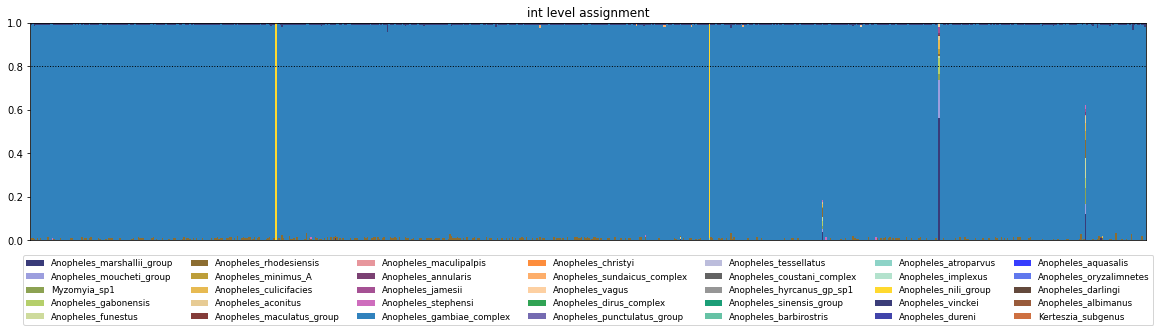

In [42]:
level='int'
assignment = result_intermediate
levelcolor=colors30
fig, ax = plt.subplots(figsize=(20,7))
assignment.plot(kind='bar', stacked=True, width=1, ax=ax, color=levelcolor)
ax.set_xticklabels('')
ax.set_xticks([])
ax.set_title("{} level assignment".format(level))
ax.hlines(.8, -.5, assignment.shape[0]-.5, color='k', ls = ':', linewidth=1)
box = ax.get_position()
ax.set_position([box.x0, box.y0+3/7*box.height, box.width, box.height*4/7])
leg1 = ax.legend(loc='upper center', ncol=7, bbox_to_anchor=(0.5, -.05), fontsize=8.7)
ax.margins(y=0)
plt.savefig(out+"plot_{}_assignment.png".format(level))
plt.savefig(out+"plot{}_assignment.pdf".format(level))

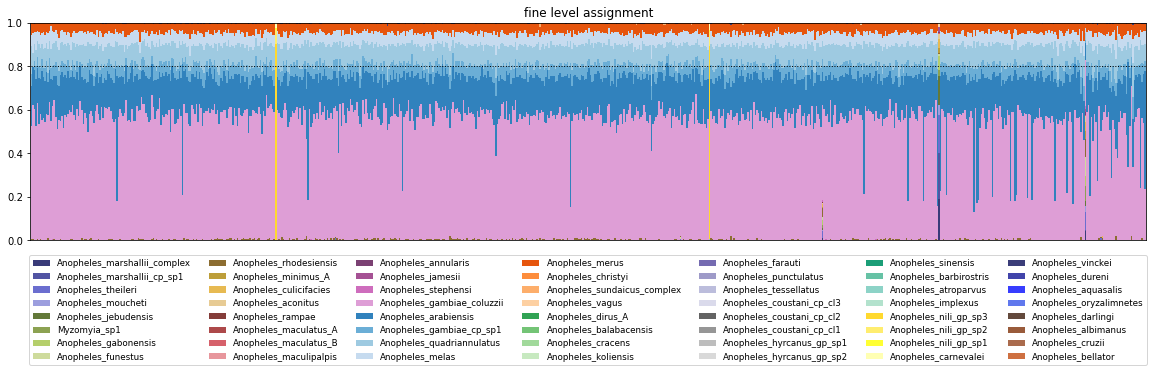

In [43]:
level='fine'
assignment = result_fine
levelcolor=colors
fig, ax = plt.subplots(figsize=(20,7))
assignment.plot(kind='bar', stacked=True, width=1, ax=ax, color=levelcolor)
ax.set_xticklabels('')
ax.set_xticks([])
ax.set_title("{} level assignment".format(level))
ax.hlines(.8, -.5, assignment.shape[0]-.5, color='k', ls = ':', linewidth=1)
box = ax.get_position()
ax.set_position([box.x0, box.y0+3/7*box.height, box.width, box.height*4/7])
leg1 = ax.legend(loc='upper center', ncol=7, bbox_to_anchor=(0.5, -.05), fontsize=8.7)
ax.margins(y=0)
plt.savefig(out+"plot_{}_assignment.png".format(level))
plt.savefig(out+"plot{}_assignment.pdf".format(level))